In [3]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [4]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
}

In [5]:
NMER = 3
CONTEXT = 200

In [6]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks/04_error_correction


In [7]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [8]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [9]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [10]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [11]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [42]:
template_events = [ev for ev in ev_map["CGT"] if not np.isnan(ev["template.mean"])]
template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT and ev["ref_position"] < len(ref)-CONTEXT]
means = [ev["template.mean"] for ev in template_events]
stdvs = [ev["template.stdv"] for ev in template_events]

### stratify by genomic position to remove sequence bias

In [43]:
print(len(set([ev["ref_position"] for ev in template_events])))
print(len(template_events))

708
59425


In [44]:
template_events = sorted(template_events, key=lambda x: x["ref_position"])
groups = {key: [x for x in group] for key, group in groupby(template_events, lambda x: x["ref_position"])}
genomic_pos = OrderedDict()
for key, group in groups.items():
    means = [x["template.mean"] for x in group]
    if(len(means) < 10): 
        print("skipped {0}".format(key))
        continue
    else:
        assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
        genomic_pos[key] = {
            "event_means" : means,
            "mean" : np.mean(means),
            "stdv" : np.std(means),
            "context_before": get_context_before(group[0], CONTEXT),
            "context_after": get_context_after(group[0], CONTEXT)
        }

skipped 18640
skipped 4016
skipped 28633


In [64]:
sort_heatmap = lambda x: (x["context_before"][0], x["context_after"][0])
occurences = sorted(genomic_pos.values(), key=sort_heatmap)
heatmap = {nt: {} for nt in NT_MAP.keys()}
for (nt_b, nt_a), group in groupby(occurences, sort_heatmap):
    heatmap[nt_b][nt_a] = mean([x["mean"] for x in group])

In [65]:
heatmap

{'A': {'A': 57.460632995988441,
  'C': 56.465783146258445,
  'G': 56.757920040430001,
  'T': 56.763295885287476},
 'C': {'A': 57.073982212946177,
  'C': 55.335179098992334,
  'G': 56.04120815955622,
  'T': 56.628844364168387},
 'G': {'A': 56.631830393098461,
  'C': 56.266916827124412,
  'G': 56.847779011396156,
  'T': 57.115875796867776},
 'T': {'A': 57.036616054382755,
  'C': 55.837800034856194,
  'G': 55.60168190663164,
  'T': 56.938667244602769}}

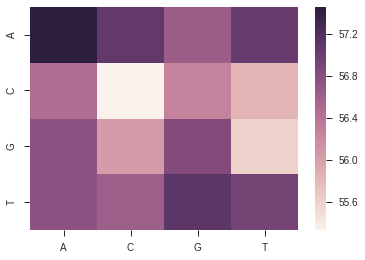

In [62]:
sns.heatmap(pandas.DataFrame(heatmap))

In [71]:
sort_heatmap = lambda x: (x["context_before"][0:2], x["context_after"][:2])
occurences = sorted(genomic_pos.values(), key=sort_heatmap)
heatmap = {"".join(nt): {} for nt in iterproduct(NT_MAP.keys(), repeat=2)}
for (nt_b, nt_a), group in groupby(occurences, sort_heatmap):
    heatmap[nt_b][nt_a] = mean([x["mean"] for x in group])

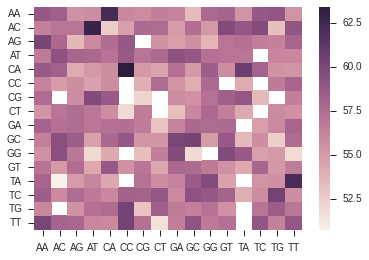

In [72]:
sns.heatmap(pandas.DataFrame(heatmap))